<a href="https://colab.research.google.com/github/dlesky/deep-learning-practice/blob/main/MS_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#My attempt to create a deep learning model that predicts COVID PCR status based on salivary mass spec data
#https://www.kaggle.com/datasets/kerneler/saliva-testing-dataset

In [ ]:
#see tensorflow documentation: https://www.tensorflow.org/tutorials/load_data/csv

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)


In [ ]:
#load csvs into pandas DataFrames
train_dataset = pd.read_csv("COVID-19_MS_dataset_train.csv")  #appears to have 2405 persons and 2715 features
test_dataset = pd.read_csv("COVID-19_MS_dataset_test.csv")  #appears to have 1877 persons and 2715 features 
print(f"train dataset has shape: {train_dataset.shape}")
print(f"test dataset has shape: {test_dataset.shape}")

train dataset has shape: (2405, 2718)
test dataset has shape: (1877, 2718)


In [ ]:
#let's glance at the data format: labels will be under PCR_result, feature data will be (3:)
train_dataset

,Person_ID,Sample_ID,PCR_result,244.17,244.38,245.48,246.44,246.69,247.36,247.99,...,15406.61,15411.6,15417.97,15468.66,16531.56,16612.52,16810.09,17207.81,18738.92,20265.36
0,1,N6,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,N6,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,N6,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,N6,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,N6,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,3253,N172,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2401,3254,N172,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2402,3255,N172,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2403,3256,N172,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#let's randomize the rows in the training and test datasets
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
#let's make sure the columns are the same in both data-sets
assert(np.all((train_dataset.columns == test_dataset.columns)==True))

In [ ]:
#define training and dev sets (~80/20%); test set is already separate 
y_train = np.transpose(pd.Series.to_numpy(train_dataset.iloc[0:2000,2]))
y_dev = np.transpose(pd.Series.to_numpy(train_dataset.iloc[2000:,2]))
y_test = np.transpose(pd.Series.to_numpy(test_dataset.iloc[:,2]))
X_train = pd.DataFrame.to_numpy(train_dataset.iloc[0:2000,3:])
X_dev = pd.DataFrame.to_numpy(train_dataset.iloc[2000:,3:])
X_test = pd.DataFrame.to_numpy(test_dataset.iloc[:,3:])

In [32]:
#convert y_training labels to 0s and 1s 
class_dict = {'pos':1, 'neg': 0}
y_train_digit = np.zeros(len(y_train))
y_dev_digit = np.zeros(len(y_dev))
for i in np.arange(0,len(y_train)):
  y_train_digit[i] = class_dict[y_train[i]]
for i in np.arange(0,len(y_dev)):
  y_dev_digit[i] = class_dict[y_dev[i]]

In [33]:
#will normalize MS feature data from (0,1) by dividing by maximum, which is found in X_train (670.6701615)
import matplotlib.pyplot as plt
X_train_norm = X_train/np.amax(X_train)
X_dev_norm = X_dev/np.amax(X_train)
X_test_norm = X_test/np.amax(X_train)
print(f"max feature in X_train_norm: {np.amax(X_train_norm)}") 
print(f"max feature in X_dev_norm: {np.amax(X_dev_norm)}") 
print(f"max feature in X_test_norm: {np.amax(X_test_norm)}")

#normalization seems to have worked!

max feature in X_train_norm: 1.0
max feature in X_train_norm: 0.8963377661762877
max feature in X_test_norm: 0.9608421738321214


In [ ]:
#picking a very simple model to start with 

model_basic = keras.Sequential (
    [
    Dense(100, "relu"),
    Dense(100, "relu"),
    Dense(1, "sigmoid")
    ]
)

In [ ]:
model_basic.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics= ["accuracy"])

In [ ]:
history_model_basic = model_basic.fit(X_train_norm, y_train_digit, epochs = 30)

In [ ]:
y_dev_pred = model_basic.predict(X_dev_norm)
y_train_pred = model_basic.predict(X_train_norm)

In [ ]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  loss = history.history['loss']
  #val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  #val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label = "training_loss")
  #plt.plot(epochs, val_loss, label = "val_loss")
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = "training_ accuracy")
  #plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


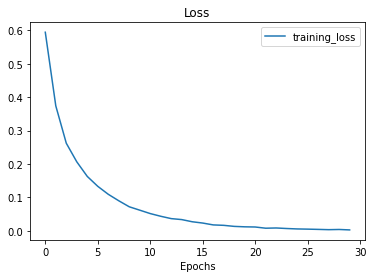

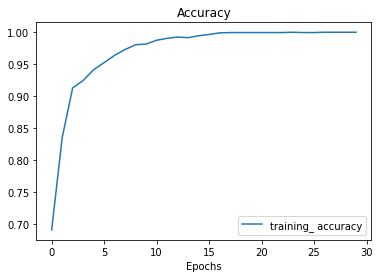

In [ ]:
plot_loss_curves(history_model_basic)

In [34]:
model_basic.evaluate(X_dev_norm, y_dev_digit)


13/13 [==============================] - 0s 4ms/step - loss: 0.1325 - accuracy: 0.9753


[0.1324617713689804, 0.9753086566925049]

In [ ]:
#97% on first try. that seemed too easy... maybe a mistake? let's see if we can get the test data for validation 